In [1]:
"""
Notebook Matrix Profile – ampiimts Python 3.11 package

Goal:
From pre processing signal with original value, normalize value, timestamp. 
We identify discord and motifs with a fix window on matrix profile methode (stumpy.maamp)
"""
# %matplotlib widget

import numpy as np
import pandas as pd
import ampiimts
import time
import os
import stumpy

In [16]:
# #import files
# folder = '../../dataset/pollution'
# pds = []
# with os.scandir(folder) as entries:
#     for entry in entries:
#         if entry.is_file() and entry.name.endswith('csv'):
#             # list of sensors with some parameters -> list[pd.DataFrame[timestamp, value1, value2, etc..., latitude, longitude]]) 
#             pds.append(pd.read_csv(folder+'/'+entry.name))
# len(pds)
# pds = pds[:10]
pds = pd.read_csv("../../dataset/air_quality/AirQualityUCI.csv")
print(len(pds.columns))
# pds = pds.iloc[:, 7:]
print(len(pds.columns))
pds = pds.copy()
# and not entry.name.startswith('pollutionData')

14
14


In [17]:
pds_normalized = ampiimts.pre_processed(pds, sort_by_variables=False)

mx_profile = ampiimts.matrix_profile(pds_normalized)



[WINDOW] Fenêtre retenue (meilleure) → 0 days 10:00:00
🔍 mmotifs → 1 motifs candidats


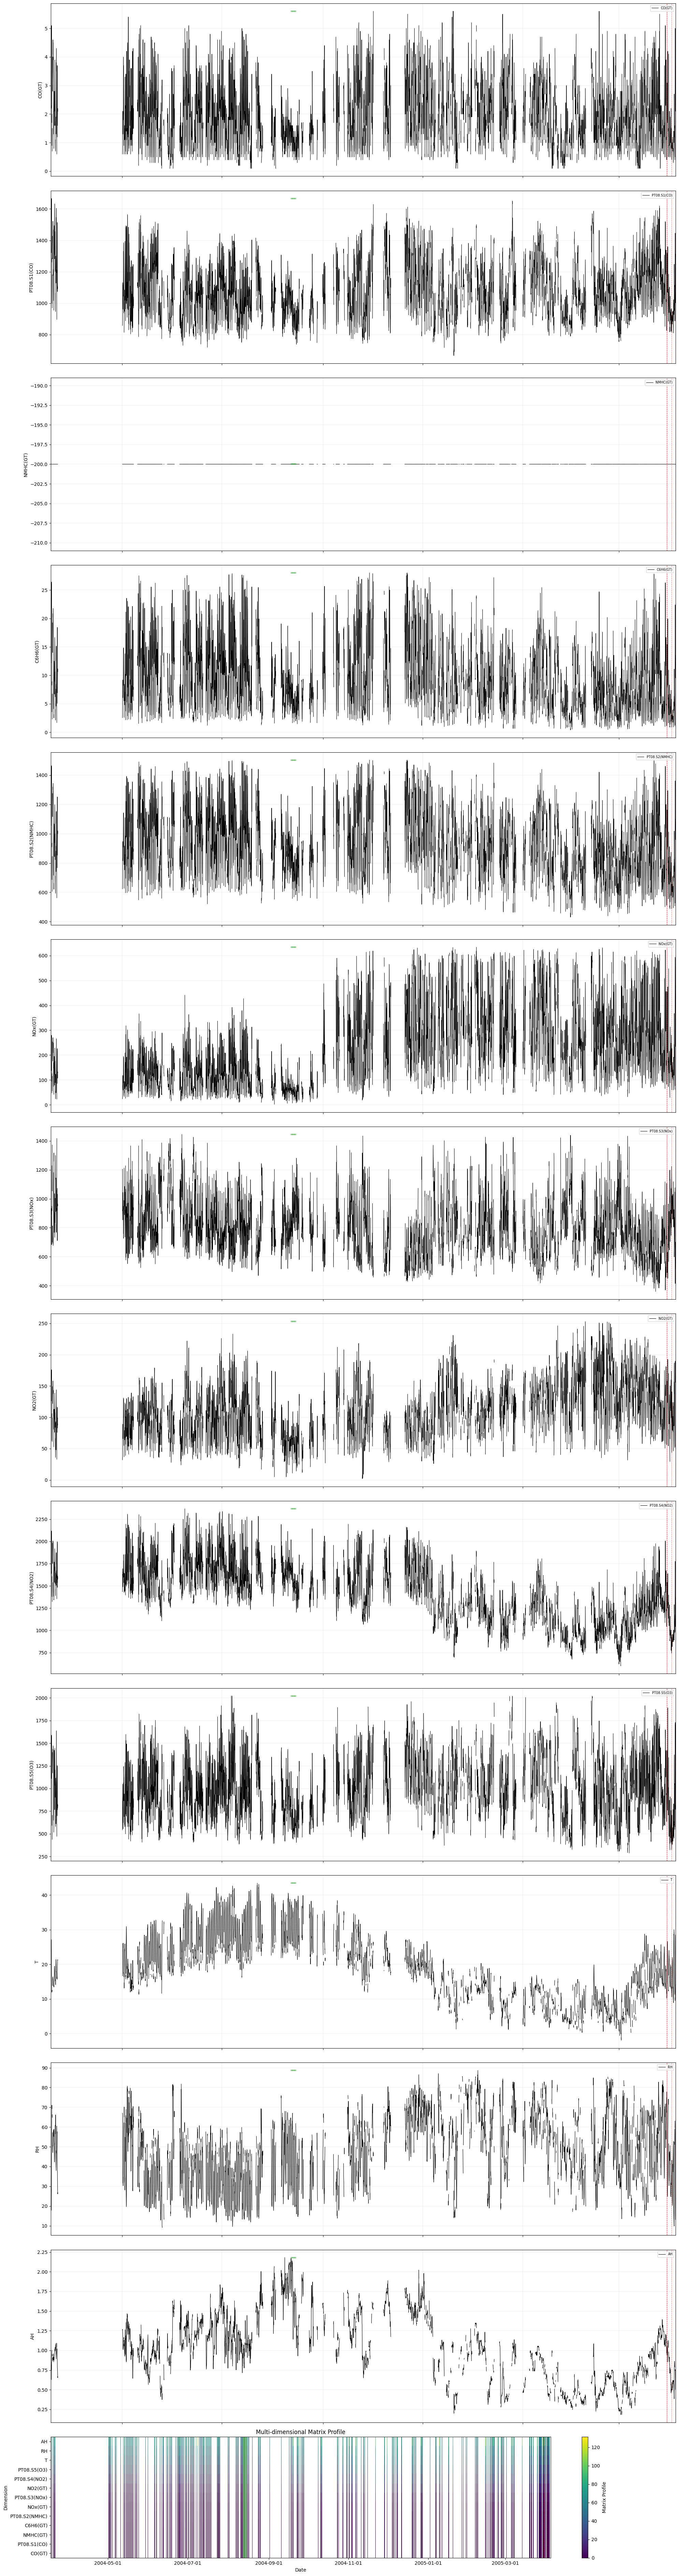

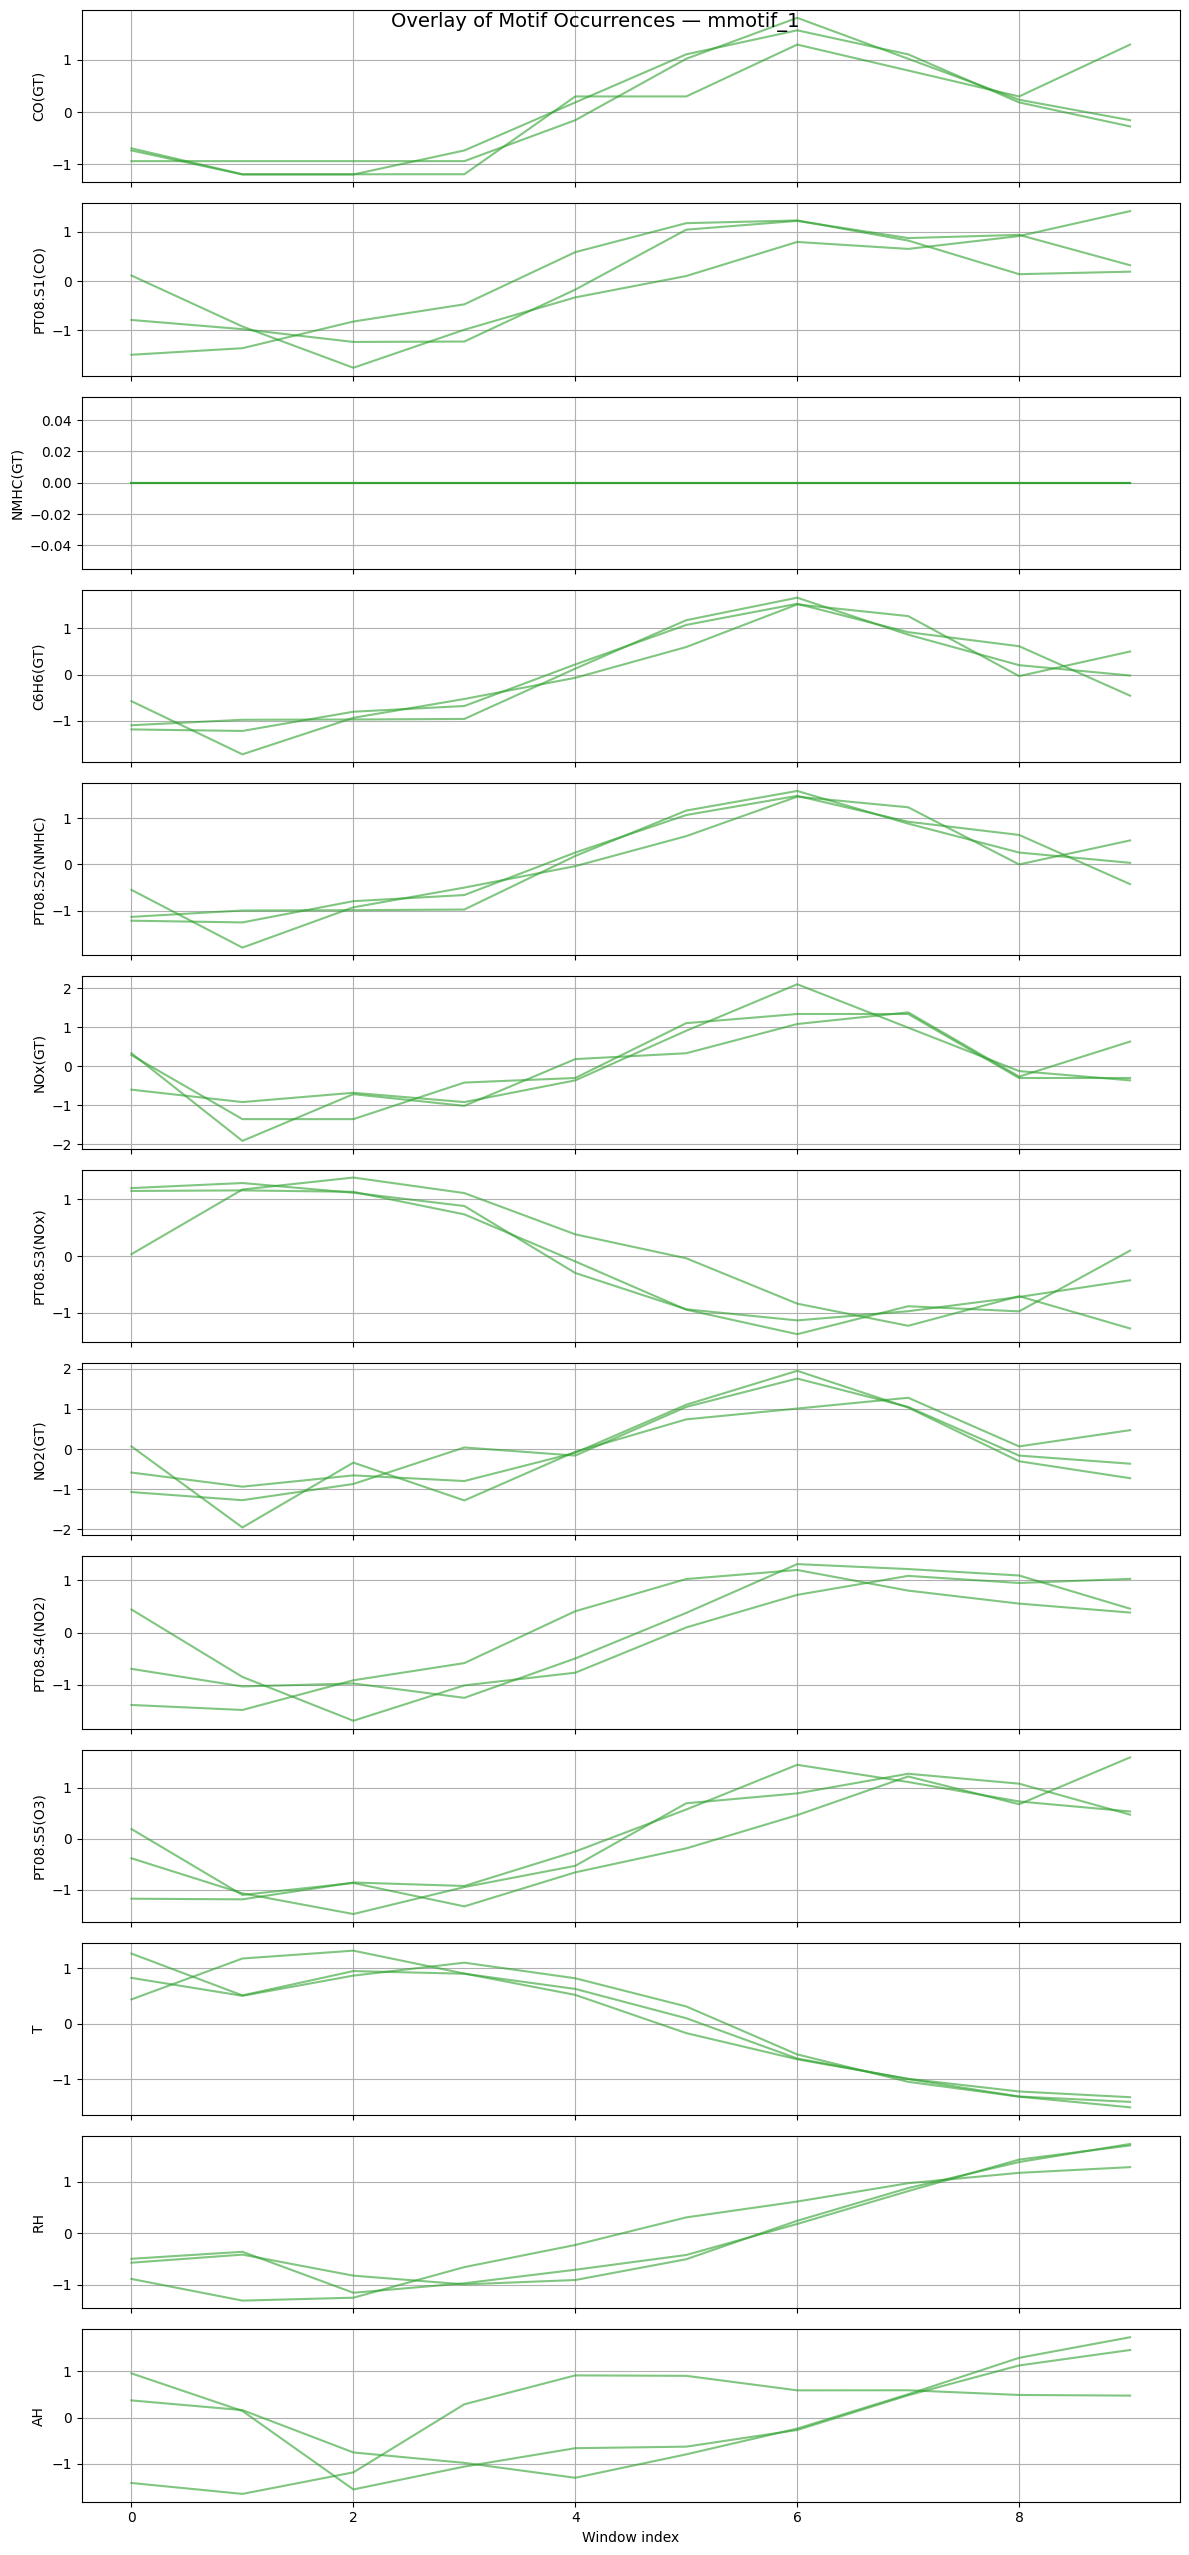

[{'pattern_label': 'mmotif_1',
  'medoid_idx': 3531,
  'motif_indices_debut': [3531, 3555, 3580]}]

In [ ]:
# for pd, mx in zip(synchronize_on_common_grid(pds), mx_profile):
#     plot_multidim_patterns_and_discords(pd, mx)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns

def plot_multidim_patterns_and_discords(df, result, tick_step=500):
    """
    Affiche :
      • chaque dimension de la série multivariée
      • les motifs (zones colorées seulement sur les dimensions actives)
      • les discords (traits rouges)
      • la heat-map du Matrix Profile
    
    Parameters
    ----------
    df : pandas.DataFrame
        Time-series multivariée indexée par dates.
    result : dict
        Sortie de discover_patterns_mstump_mixed :
            - "matrix_profile"  : DataFrame (len=n−m+1 × n_dim), index DatetimeIndex
            - "window_size"     : int
            - "discord_indices" : list
            - "patterns"        : list de dicts
            - "motif_subspaces" : list[np.ndarray[bool]] (facultatif)
    tick_step : int
        Pas pour les ticks (inutile si AutoDateLocator utilisé).
    """
    # --- 0) Récupérations --------------------------------------------
    profile_df   = result["matrix_profile"]             # (n-m+1) × n_dim
    mp           = profile_df.values.T                  # (n_dim, prof_len)
    center_dates = profile_df.index.to_pydatetime()
    window_size  = result["window_size"]
    discords     = result.get("discord_indices", [])
    patterns     = result.get("patterns", [])
    subspaces    = result.get("motif_subspaces", [None] * len(patterns))

    n_dim, prof_len = mp.shape
    figsize = (20, 1.5 * (n_dim + 1))

    # --- 1) Préparation des bords X pour la heat-map ------------------
    dnums = mdates.date2num(center_dates)
    diffs = np.diff(dnums)
    xedges = np.empty(prof_len + 1)
    xedges[1:-1] = dnums[:-1] + diffs / 2
    xedges[0]    = dnums[0] - diffs[0] / 2
    xedges[-1]   = dnums[-1] + diffs[-1] / 2
    yedges = np.arange(n_dim + 1)

    # --- 2) Création figure + axes -----------------------------------
    fig, axs = plt.subplots(
        n_dim + 1, 1,
        figsize=(figsize[0], figsize[1] * (1 + 0.2 * n_dim)),
        sharex=True,
        gridspec_kw={"height_ratios": [1] * n_dim + [0.7]},
    )

    motif_colors = ["tab:green", "tab:purple", "tab:blue", "tab:orange",
                    "tab:brown", "tab:pink", "tab:gray", "tab:olive"]

    # Pré-compute : pour chaque motif, la liste des dimensions actives
    pattern_dims = []
    for sp in subspaces:
        if sp is None:
            pattern_dims.append(set(range(n_dim)))
        else:
            pattern_dims.append(set(np.where(np.atleast_1d(sp))[0]))

    # --- 3) Tracé des séries, motifs et discords ---------------------
    for dim, col in enumerate(df.columns):
        ax = axs[dim]
        ax.plot(df.index, df[col], color="black", label=col, linewidth=0.8)

        # motifs (axvspan uniquement si la dimension est active)
        for pat_id, pat in enumerate(patterns):
            c = motif_colors[pat_id % len(motif_colors)]
            if dim not in pattern_dims[pat_id]:
                continue  # dimension non pertinente pour ce motif
            for j, s in enumerate(pat["motif_indices_debut"]):
                e = s + window_size
                ax.axvspan(
                    df.index[s], df.index[e],
                    color=c,
                    alpha=0.25,
                    label=(pat["pattern_label"] if (j == 0 and dim == 0) else None),
                )

        # discords (traits verticaux rouges)
        for d in discords:
            ax.axvline(df.index[d], color="red", linestyle="--", alpha=0.5, linewidth=0.8)

        ax.set_ylabel(col)
        ax.grid(True, linewidth=0.3, alpha=0.6)

        # mise en forme de l'axe X
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        ax.tick_params(axis="x", rotation=45, labelsize="small")
        ax.legend(loc="upper right", fontsize="x-small")

    # --- 4) Heat-map du Matrix Profile -------------------------------
    axh = axs[-1]
    cmap = plt.cm.viridis.copy()
    cmap.set_bad("white")

    mesh = axh.pcolormesh(
        xedges, yedges, mp,
        cmap=cmap,
        shading="flat",
    )
    fig.colorbar(mesh, ax=axh, label="Matrix Profile")

    # Redessiner discords sur la heat-map
    for d in discords:
        xd = mdates.date2num(df.index[d])
        axh.axvline(xd, color="red", linestyle="--", alpha=0.5, linewidth=0.8)

    # Redessiner motifs (rectangles) mais uniquement sur les dims actives
    for pat_id, pat in enumerate(patterns):
        c = motif_colors[pat_id % len(motif_colors)]
        active_dims = pattern_dims[pat_id]
        if not active_dims:
            continue
        ymin = min(active_dims)
        ymax = max(active_dims) + 1
        for s in pat["motif_indices_debut"]:
            x0 = mdates.date2num(df.index[s])
            x1 = mdates.date2num(df.index[s + window_size])
            rect = plt.Rectangle(
                (x0, ymin),
                x1 - x0,
                ymax - ymin,
                edgecolor=c,
                facecolor="none",
                linewidth=1.2,
                alpha=0.8,
            )
            axh.add_patch(rect)

    # --- 5) Mise en forme finale -------------------------------------
    axh.set_xlim(df.index[0], df.index[-1])
    axh.set_xlabel("Date")
    axh.set_ylabel("Dimension")
    axh.set_yticks(np.arange(n_dim) + 0.5)
    axh.set_yticklabels(df.columns)
    axh.set_title("Multi-dimensional Matrix Profile")

    plt.tight_layout()
    plt.show()

def plot_motif_overlays(df, result, normalize=True):
    """
    Pour chaque motif détecté, affiche ses occurrences superposées par dimension.
    """
    window_size = result["window_size"]
    patterns = result["patterns"]
    n_dim = df.shape[1]
    motif_colors = ["tab:green", "tab:purple", "tab:blue", "tab:orange", "tab:brown", "tab:pink"]

    for i, pat in enumerate(patterns):
        fig, axs = plt.subplots(n_dim, 1, figsize=(12, 2 * n_dim), sharex=True)
        if n_dim == 1:
            axs = [axs]
        motif_label = pat["pattern_label"]
        indices = pat["motif_indices_debut"]
        c = motif_colors[i % len(motif_colors)]

        for dim, col in enumerate(df.columns):
            ax = axs[dim]
            for idx in indices:
                segment = df.iloc[idx:idx + window_size, dim]
                if normalize:
                    segment = (segment - segment.mean()) / (segment.std() + 1e-8)
                ax.plot(np.arange(len(segment)), segment, alpha=0.6, color=c)
            ax.set_ylabel(col)
            ax.grid(True)

        axs[-1].set_xlabel("Window index")
        fig.suptitle(f"Overlay of Motif Occurrences — {motif_label}", fontsize=14)
        plt.tight_layout()
        plt.show()

plot_multidim_patterns_and_discords(ampiimts.interpolate(pds), mx_profile)
plot_motif_overlays(ampiimts.interpolate(pds), mx_profile)
mx_profile.get("patterns", [])


In [5]:
# pds_interpolate = ampiimts.interpolate(pds)
# # pds = pds.set_index("timestamp")  # définit la colonne 'timestamp' comme index

# motif = pds_interpolate["T"].loc["2004-12-15 18:00:00" : "2004-12-16 12:00:00"]
# motif.head()


In [6]:
# import pandas as pd

# # 1) Lire le fichier Excel
# df = pd.read_excel('../../dataset/air_quality/AirQualityUCI.xlsx', sheet_name=0)

# # 2) S’assurer que la colonne Date est bien en datetime (elle l’est souvent déjà)
# df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# # 3) Créer un timedelta à partir de la colonne Time
# #    On cast en str au cas où ce soit déjà un datetime.time
# df['TimeDelta'] = pd.to_timedelta(df['Time'].astype(str))

# # 4) Construire la colonne Timestamp
# df['timestamp'] = df['Date'] + df['TimeDelta']

# # 5) (Optionnel) Supprimer la colonne intermédiaire
# df.drop(columns=['TimeDelta', 'Date', 'Time'], inplace=True)

# # 6) Enregistrer en CSV
# df.to_csv('../../dataset/air_quality/AirQualityUCI.csv', index=False)
